In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
#!pip install segmentation_models --no-index --find-links=file:///kaggle/input/seg-models-offline

In [3]:
#import segmentation_models as sm
#sm.set_framework('tf.keras')

#sm.framework()
#from segmentation_models import Unet

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import keras
import glob
from tensorflow.keras.utils import Sequence
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf


from keras import layers
from keras.layers import BatchNormalization

In [5]:
train_df = pd.read_csv("../input/hubmap-organ-segmentation/train.csv")
test_df = pd.read_csv("../input/hubmap-organ-segmentation/test.csv")


In [6]:
train_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male


In [7]:
train_df['img_height'].value_counts()

3000    326
2631      2
2416      2
2942      2
2790      2
2764      2
2654      2
2539      1
2680      1
2727      1
2308      1
2867      1
2783      1
2869      1
2760      1
2630      1
2511      1
2593      1
2675      1
3070      1
Name: img_height, dtype: int64

In [8]:
train_df['img_width'].value_counts()

3000    326
2631      2
2416      2
2942      2
2790      2
2764      2
2654      2
2539      1
2680      1
2727      1
2308      1
2867      1
2783      1
2869      1
2760      1
2630      1
2511      1
2593      1
2675      1
3070      1
Name: img_width, dtype: int64

In [9]:
pd.crosstab(train_df['img_height'],train_df['img_width'])

#Height=Width for all images

img_width,2308,2416,2511,2539,2593,2630,2631,2654,2675,2680,2727,2760,2764,2783,2790,2867,2869,2942,3000,3070
img_height,,,,,,,,,,,,,,,,,,,,
2308,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2416,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2511,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2539,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2593,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2630,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2631,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
2654,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
2675,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [10]:
print('Minimum width:',train_df['img_width'].min())
print('Maximum width:',train_df['img_width'].max())
print('Minimum height:',train_df['img_height'].min())
print('Maximum height:',train_df['img_height'].max())

Minimum width: 2308
Maximum width: 3070
Minimum height: 2308
Maximum height: 3070


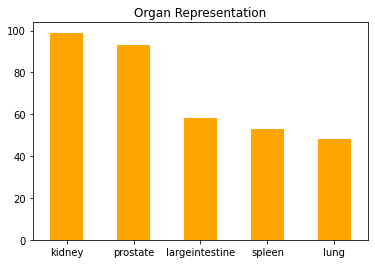

In [11]:
train_df['organ'].value_counts().plot(kind='bar',color='orange')
plt.title('Organ Representation')
plt.xticks(rotation=360)
plt.show()

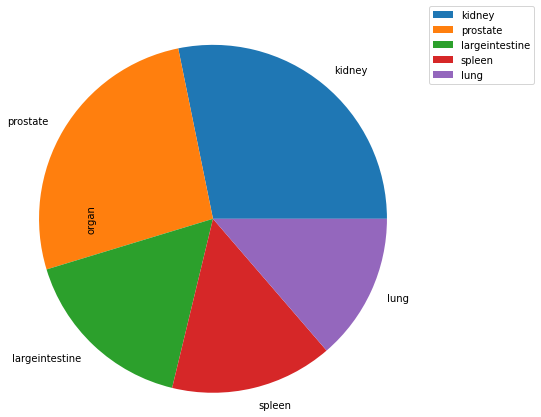

In [12]:
train_df['organ'].value_counts().plot(kind='pie',radius=2)
plt.legend(bbox_to_anchor=(1, 1., 1, 0.5))
plt.show()

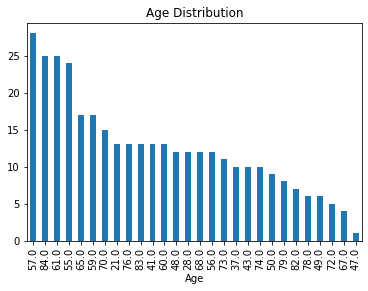

In [13]:
train_df['age'].value_counts().plot(kind='bar')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.show()


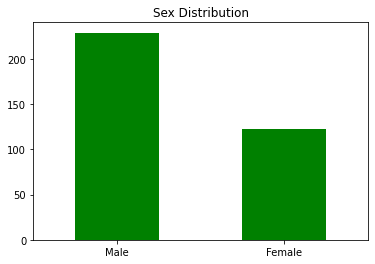

In [14]:
train_df['sex'].value_counts().plot(kind='bar',color='green')
plt.title('Sex Distribution')
plt.xticks(rotation=360)
plt.show()

In [15]:
train_df['pixel_size'].value_counts()

0.4    351
Name: pixel_size, dtype: int64

In [16]:
train_df['tissue_thickness'].value_counts()

4    351
Name: tissue_thickness, dtype: int64

In [17]:
#helper functions
def rle_decoder(n,df= train_df):
    
    ht = int(df['img_height'][n])
    wt = int(df['img_width'][n])
    
    mask = np.zeros((ht * wt),dtype = np.uint8)
    values = np.asarray(df['rle'][n].split(" "),dtype='int')
    
    start_pt = values[::2] - 1
    length = values[1::2]
    end_pt = start_pt + length
    
    for start, end in zip(start_pt, end_pt):
        mask[start:end] = 1
    

    mask = mask.reshape(wt,ht)
    mask = mask.T
    mask = mask.astype(np.uint8)
    return mask

def mask_to_rle(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0],pixels,[0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] 
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

**Plotting Images**

Before plotting, let us merge the train_images file path to our train.csv dataframe

In [18]:
train_img_path = glob.glob('../input/hubmap-organ-segmentation/train_images/*')
paths_df = pd.DataFrame(columns=['paths'])
paths_df['paths'] = train_img_path

paths_df['id'] = paths_df['paths'].apply(lambda x: x.split('/')[-1].replace('.tiff',"")).astype('int')

train_df = train_df.merge(paths_df,on='id')


In [19]:
train_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,paths
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../input/hubmap-organ-segmentation/train_image...
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../input/hubmap-organ-segmentation/train_image...
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../input/hubmap-organ-segmentation/train_image...
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../input/hubmap-organ-segmentation/train_image...
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../input/hubmap-organ-segmentation/train_image...
...,...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male,../input/hubmap-organ-segmentation/train_image...
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male,../input/hubmap-organ-segmentation/train_image...
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male,../input/hubmap-organ-segmentation/train_image...
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male,../input/hubmap-organ-segmentation/train_image...


Display images with and without masks


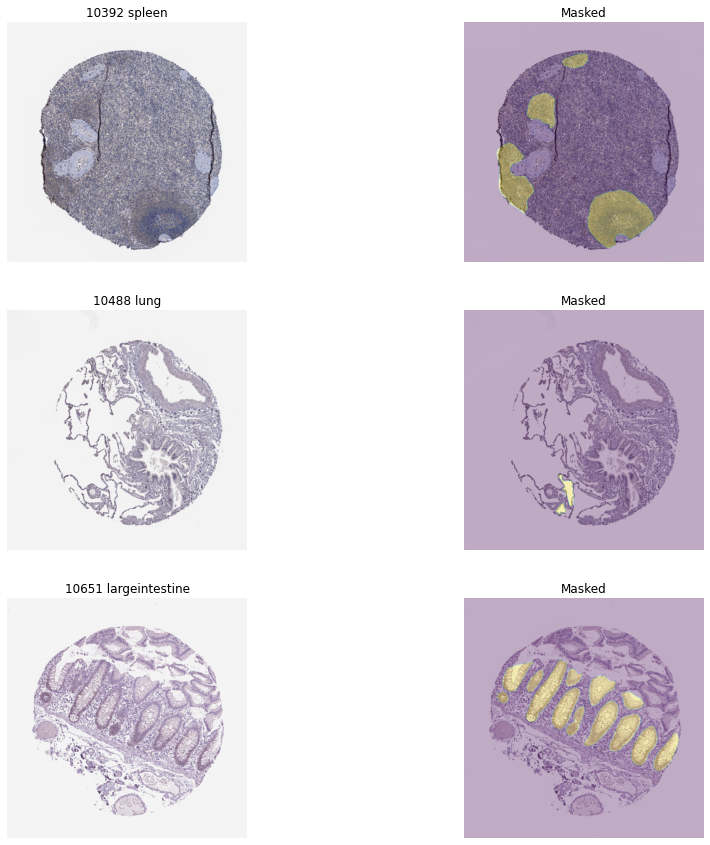

In [20]:
plt.figure(figsize=(15,15))
n = [2,3,6]
a = 1
for i in n:
    img1 = Image.open(train_df['paths'][i])
    img1 = np.array(img1)
    plt.subplot(3,2,a)
    plt.title(str(train_df['id'][i])+' '+str(train_df['organ'][i]))
    plt.axis('off')
    plt.imshow(img1,alpha=1)
    a = a + 1

    plt.subplot(3,2,a)
    plt.imshow(img1)
    plt.subplot(3,2,a)
    plt.axis('off')
    plt.title('Masked')
    plt.imshow(rle_decoder(i,train_df),alpha=0.3)
    a = a + 1
    

In [21]:
def dice_coef(y_true, y_pred, smooth=1):
    # flatten
    y_true_f = K.flatten(K.cast(y_true, np.float32))
    #y_pred_f = K.flatten(K.cast(K.argmax(y_pred, axis=-1), np.float32))
    y_pred_f = K.flatten(K.cast(K.argmax(y_pred, axis=-1), np.float32))
    # compute numerator and denominator
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    # apply dice formula
    dice = K.mean((2.*intersection + smooth)/(union + smooth))
    return dice

def weighted_loss(y_true, y_pred):
    # Calculate the base loss
    ce = K.sparse_categorical_crossentropy(y_true, y_pred)
    # Apply the weights
    one_weight = 1.0
    zero_weight = 1e-2
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weight_vector = K.squeeze(weight_vector, axis=-1)
    weighted_ce = weight_vector * ce

    # Return the mean error
    return K.mean(weighted_ce)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

**Building datagenerator**

In [22]:

#["0-prostate","1-spleen","2-lung","3-largeintestine","4-kidney"]

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, df, batch_size=16, n_classes=5, shuffle=False,to_fit=True):
  
        'Initialization'
        self.df = df
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.df))
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size: (index+1)*self.batch_size]
        X = np.empty((self.batch_size,512,512,3),dtype=np.float32)
        y = np.empty((self.batch_size,512,512,1),dtype=np.uint8)
        
        if self.to_fit == True:
            
            for i, img_path in enumerate(self.df['paths'].iloc[indexes]):
                img = self.read_img(img_path)
                X[i,] = img
                dims = int(self.df['img_height'].iloc[indexes[i]])
                mask = self.get_mask(dims,indexes[i])
                y[i,] = mask
                
            
            return X, y
          
        else:
            for i, img_path in enumerate(self.df['paths'].iloc[indexes]):
                img = self.read_img(img_path)
                X[i,] = img
                
            return X
        
        
    def read_img(self, path):
        image =  Image.open(path)
        image = image.resize((512,512))
        image = np.asarray(image)
        image = image.astype(np.float32)
        return image/255
    
    def get_mask(self,dim,n):
    
        mask = np.zeros((dim * dim),dtype = np.uint8)
        values = np.asarray(self.df['rle'].iloc[n].split(" "),dtype='int')
    
        start_pt = values[::2] - 1
        length = values[1::2]
        end_pt = start_pt + length
    
        for start, end in zip(start_pt, end_pt):
            mask[start:end] = 1
    

        mask = mask.reshape(dim,dim)
        mask = mask.T
        mask = mask.astype(np.uint8)
        
        res = cv2.resize(mask, dsize=(512, 512))
        res = np.expand_dims(res, axis=-1)
        
        return res

In [23]:
from sklearn.model_selection import train_test_split

y = train_df['organ']
train,val = train_test_split(train_df,test_size=0.1,stratify=y)
train

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,paths
202,28126,spleen,HPA,3000,3000,0.4,4,3187369 48 3190367 53 3193364 67 3196363 70 31...,70.0,Female,../input/hubmap-organ-segmentation/train_image...
309,676,largeintestine,HPA,3000,3000,0.4,4,1306250 17 1309247 22 1309446 9 1312246 24 131...,79.0,Female,../input/hubmap-organ-segmentation/train_image...
164,24782,lung,HPA,3000,3000,0.4,4,4734932 2 4737931 4 4740931 5 4743917 1 474393...,78.0,Male,../input/hubmap-organ-segmentation/train_image...
275,4265,kidney,HPA,3000,3000,0.4,4,871860 24 874856 30 877853 35 880853 37 883853...,41.0,Female,../input/hubmap-organ-segmentation/train_image...
62,15787,kidney,HPA,3000,3000,0.4,4,1776723 16 1779722 17 1782722 17 1785717 23 17...,68.0,Female,../input/hubmap-organ-segmentation/train_image...
...,...,...,...,...,...,...,...,...,...,...,...
270,3409,prostate,HPA,3000,3000,0.4,4,832291 24 835289 28 838275 51 841274 53 844273...,55.0,Male,../input/hubmap-organ-segmentation/train_image...
156,24100,kidney,HPA,3000,3000,0.4,4,1392950 5 1395945 19 1398942 26 1401938 31 140...,68.0,Female,../input/hubmap-organ-segmentation/train_image...
29,1229,prostate,HPA,2654,2654,0.4,4,229957 31 232610 33 235217 84 237869 87 240521...,37.0,Male,../input/hubmap-organ-segmentation/train_image...
91,1850,largeintestine,HPA,3000,3000,0.4,4,832616 11 835608 23 838603 35 841599 41 844597...,84.0,Female,../input/hubmap-organ-segmentation/train_image...


In [24]:
train_gen = DataGenerator(df = train,shuffle=True,batch_size=8)
val_gen = DataGenerator(df = val,shuffle=True,batch_size=8)

In [25]:
def get_model(image_size, num_classes):
    inputs = keras.Input(shape=(image_size, image_size, 3))
    x = layers.Conv2D(32, 3, strides=2, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x) 
    x = layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, 3, strides=2, activation='relu', padding='same')(x)
    
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(256, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    outputs = layers.Conv2D(num_classes, 3, activation='sigmoid', padding='same')(x)
    model = keras.Model(inputs, outputs)
    return model

model = get_model(512, 1)



2022-08-18 14:02:43.467507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 14:02:43.793231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 14:02:43.797251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 14:02:43.802589: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       73856 

In [27]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',dice_coef])

In [28]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
   # callbacks=[checkpoint, early_stopping],
    use_multiprocessing=False,
    #workers=4,
    epochs=60
 )

2022-08-18 14:02:52.573055: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-08-18 14:02:59.691686: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


39/39 [==============================] - 144s 3s/step - loss: 0.3867 - accuracy: 0.8955 - dice_coef: 5.4400e-06 - val_loss: 0.3031 - val_accuracy: 0.9123 - val_dice_coef: 5.6634e-06
Epoch 2/60
39/39 [==============================] - 89s 2s/step - loss: 0.2975 - accuracy: 0.9006 - dice_coef: 5.3745e-06 - val_loss: 0.3161 - val_accuracy: 0.9024 - val_dice_coef: 5.3890e-06
Epoch 3/60
39/39 [==============================] - 57s 1s/step - loss: 0.2762 - accuracy: 0.9003 - dice_coef: 5.4261e-06 - val_loss: 0.2895 - val_accuracy: 0.9078 - val_dice_coef: 7.1535e-06
Epoch 4/60
39/39 [==============================] - 54s 1s/step - loss: 0.2766 - accuracy: 0.8996 - dice_coef: 5.4419e-06 - val_loss: 0.2642 - val_accuracy: 0.9100 - val_dice_coef: 8.6987e-06
Epoch 5/60
39/39 [==============================] - 53s 1s/step - loss: 0.2563 - accuracy: 0.8999 - dice_coef: 5.1299e-06 - val_loss: 0.3089 - val_accuracy: 0.8980 - val_dice_coef: 4.9535e-06
Epoch 6/60
39/39 [==============================] 

In [29]:
check_df = pd.DataFrame(train_df.iloc[0:3])
check_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,paths
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../input/hubmap-organ-segmentation/train_image...
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../input/hubmap-organ-segmentation/train_image...
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../input/hubmap-organ-segmentation/train_image...


In [30]:
def preprocess_image(path):
    image = tf.keras.utils.load_img(path)
    original_shape = tf.keras.utils.img_to_array(image).shape
    image_processed = tf.keras.utils.img_to_array(tf.keras.utils.array_to_img(image).resize((512, 512)))/255
    return image_processed,original_shape

In [31]:
test_gen = DataGenerator(test_df,batch_size=1,to_fit=False)
check_gen = DataGenerator(check_df,batch_size=1,to_fit=False)

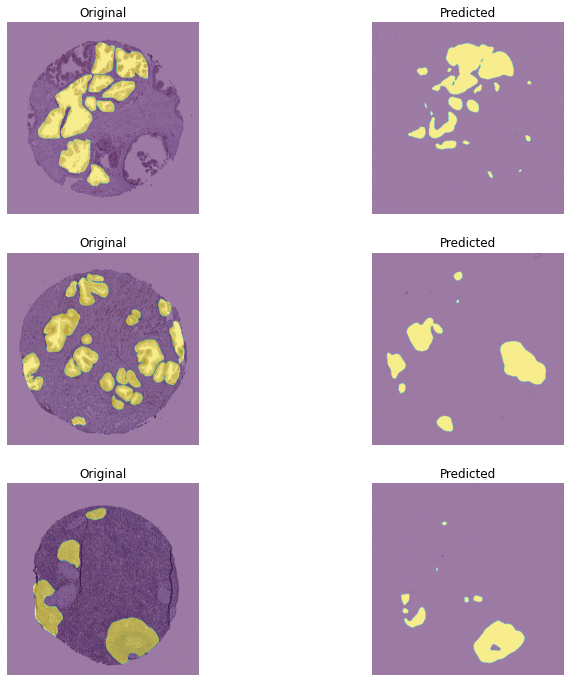

In [32]:
check_predictions = model.predict(check_gen)
check_mask = np.where(check_predictions > 0.5,1,0)
check_mask.shape

plt.figure(figsize=(12,12))
a = 1
for i in range(len(check_df)):
    
    img = Image.open(check_df['paths'][i])
    img = np.array(img)
    plt.subplot(3,2,a)
    plt.title('Original')
    plt.axis('off')
    plt.imshow(img)
    plt.subplot(3,2,a)
    plt.imshow(rle_decoder(i,check_df),alpha=0.5)
    
    
    plt.subplot(3,2,a+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Predicted')
    plt.subplot(3,2,a+1)
    plt.imshow(check_mask[i],alpha=0.5)
    
    a+=2

In [33]:
test_df = pd.read_csv('../input/hubmap-organ-segmentation/test.csv')
test_ids = test_df['id']
test_dir = '../input/hubmap-organ-segmentation/test_images'

ids = []
rles = []
for id in test_ids:
    path = os.path.join(test_dir, f"{id}.tiff")
    image,original_shape = preprocess_image(path)
    pred = model.predict(np.expand_dims(image, axis=0))
    pred_mask = np.where(pred > 0.5, 1, 0)[0]
    resized_pred_mask = tf.keras.utils.array_to_img(pred_mask, scale=False).resize((original_shape[0], original_shape[1]), resample=0)
    resized_pred_mask_array = tf.keras.utils.img_to_array(resized_pred_mask, dtype='uint8')
    rle = mask_to_rle(resized_pred_mask_array)
    ids.append(id)
    rles.append(rle)
    
submission_df = pd.DataFrame({'id':ids,'rle':rles})
submission_df.to_csv('submission.csv', index=False)

In [34]:
submission_df

,id,rle
0,10078,455305 4 455313 4 457328 4 457336 4 459351 4 4...
